Machine Learning 1 project 
Kunal Inglunkar 

Pneumonia Detection Using CNN

Dataset source : https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score, confusion_matrix, precision_score, recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use('fivethirtyeight')
import pickle 
import os 
import numpy as np
import cv2 
%matplotlib inline

In [ ]:

import numpy as np 
import pandas as pd 

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 200
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

training and testing data

In [ ]:
train = get_training_data('/content/drive/My Drive/Colab Notebooks/train')

<ipython-input-3-149d7cc0a3f4>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [ ]:
test=get_training_data('/content/drive/My Drive/Colab Notebooks/test')
val = get_training_data('/content/drive/My Drive/Colab Notebooks/val')

<ipython-input-3-149d7cc0a3f4>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [ ]:
pnenumonia = 0 
normal = 0 

for i, j in train:
    if j == 0:
        pnenumonia+=1
    else:
        normal+=1
        
print('Pneumonia:', pnenumonia)
print('Normal:', normal)
# print('Pneumonia - Normal:', pnenumonia-normal)

Pneumonia: 3875
Normal: 1341


In [ ]:
# 



<Axes: ylabel='count'>

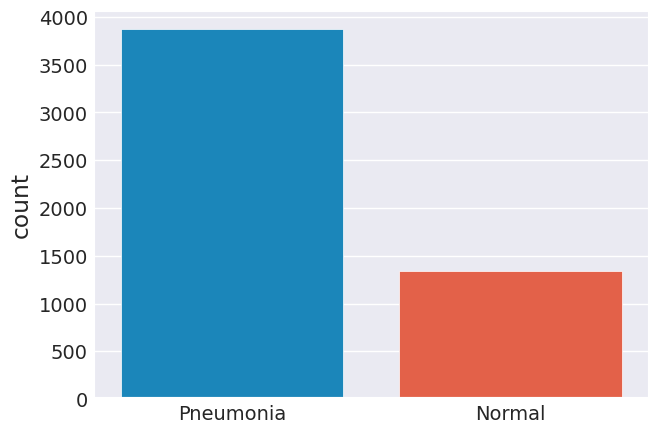

In [ ]:
counts = {"Pneumonia": pnenumonia, "Normal": normal}

# Convert the counts to a pandas dataframe
df_counts = pd.DataFrame.from_dict(counts, orient='index', columns=['count'])

# Plot the countplot using the dataframe
sns.set_style('darkgrid')
sns.barplot(data=df_counts, x=df_counts.index, y='count')

training images

Text(0.5, 1.0, 'NORMAL')

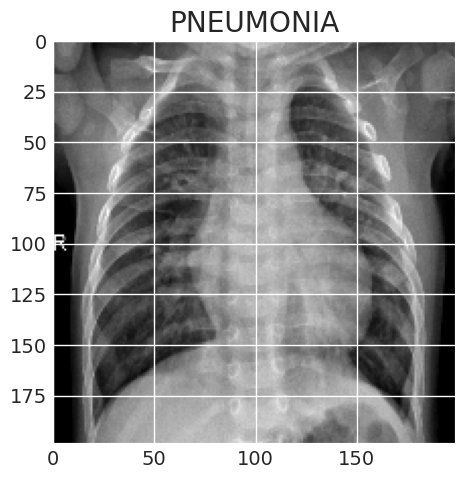

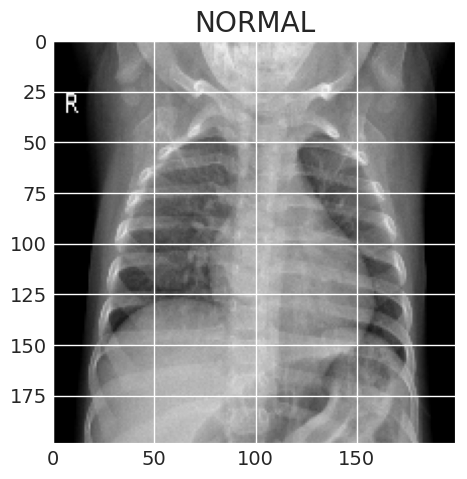

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

Combine the validation data into the training data because it does not contain enough examples

In [ ]:
X = []
y = []

for feature, label in train:
    X.append(feature)
    y.append(label)

for feature, label in test:
    X.append(feature)
    y.append(label)
    
for feature, label in val:
    X.append(feature)
    y.append(label)


# resize data for deep learning 
X = np.array(X).reshape(-1, img_size, img_size, 1)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=32)

In [ ]:
#Normalize the data
X_train = X_train / 255
X_test = X_test / 255
X_val = X_val / 255

Data augmentation

In [ ]:
# good for balancing out disproportions in the dataset 
datagen = ImageDataGenerator(
        featurewise_center=False, 
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=90, 
        zoom_range = 0.1, 
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True)  

datagen.fit(X_train)

In [ ]:
model = Sequential()

model.add(Conv2D(256, (3, 3), input_shape=X_train.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=1))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors

model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)
adam = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 256)     2560      
                                                                 
 activation (Activation)     (None, 200, 200, 256)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 256)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 256)    400       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      147520    
                                                                 
 activation_1 (Activation)   (None, 100, 100, 64)      0

In [ ]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=10), callbacks=[early_stop], validation_data=(X_val, y_val), epochs=15)

Epoch 1/15
375/375 [==============================] - 25s 32ms/step - loss: 0.6368 - acc: 0.6979 - val_loss: 0.7944 - val_acc: 0.7407
Epoch 2/15
375/375 [==============================] - 11s 28ms/step - loss: 0.5205 - acc: 0.7305 - val_loss: 0.4799 - val_acc: 0.7257
Epoch 3/15
375/375 [==============================] - 11s 28ms/step - loss: 0.4743 - acc: 0.7435 - val_loss: 0.4088 - val_acc: 0.7834
Epoch 4/15
375/375 [==============================] - 11s 29ms/step - loss: 0.4231 - acc: 0.7846 - val_loss: 0.3888 - val_acc: 0.7951
Epoch 5/15
375/375 [==============================] - 11s 28ms/step - loss: 0.4100 - acc: 0.8001 - val_loss: 0.3968 - val_acc: 0.7908
Epoch 6/15
375/375 [==============================] - 11s 28ms/step - loss: 0.3759 - acc: 0.8233 - val_loss: 0.3118 - val_acc: 0.8741
Epoch 7/15
375/375 [==============================] - 11s 28ms/step - loss: 0.3545 - acc: 0.8337 - val_loss: 0.3130 - val_acc: 0.8762
Epoch 8/15
375/375 [==============================] - 11s 28ms

In [ ]:
model.evaluate(X_test, y_test)

37/37 [==============================] - 1s 18ms/step - loss: 0.2281 - acc: 0.9189


[0.2280900776386261, 0.9189419746398926]

In [ ]:
print("Loss of the model is - " , model.evaluate(X_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

37/37 [==============================] - 0s 12ms/step - loss: 0.2281 - acc: 0.9189
Loss of the model is -  0.2280900776386261
37/37 [==============================] - 0s 12ms/step - loss: 0.2281 - acc: 0.9189
Accuracy of the model is -  91.89419746398926 %


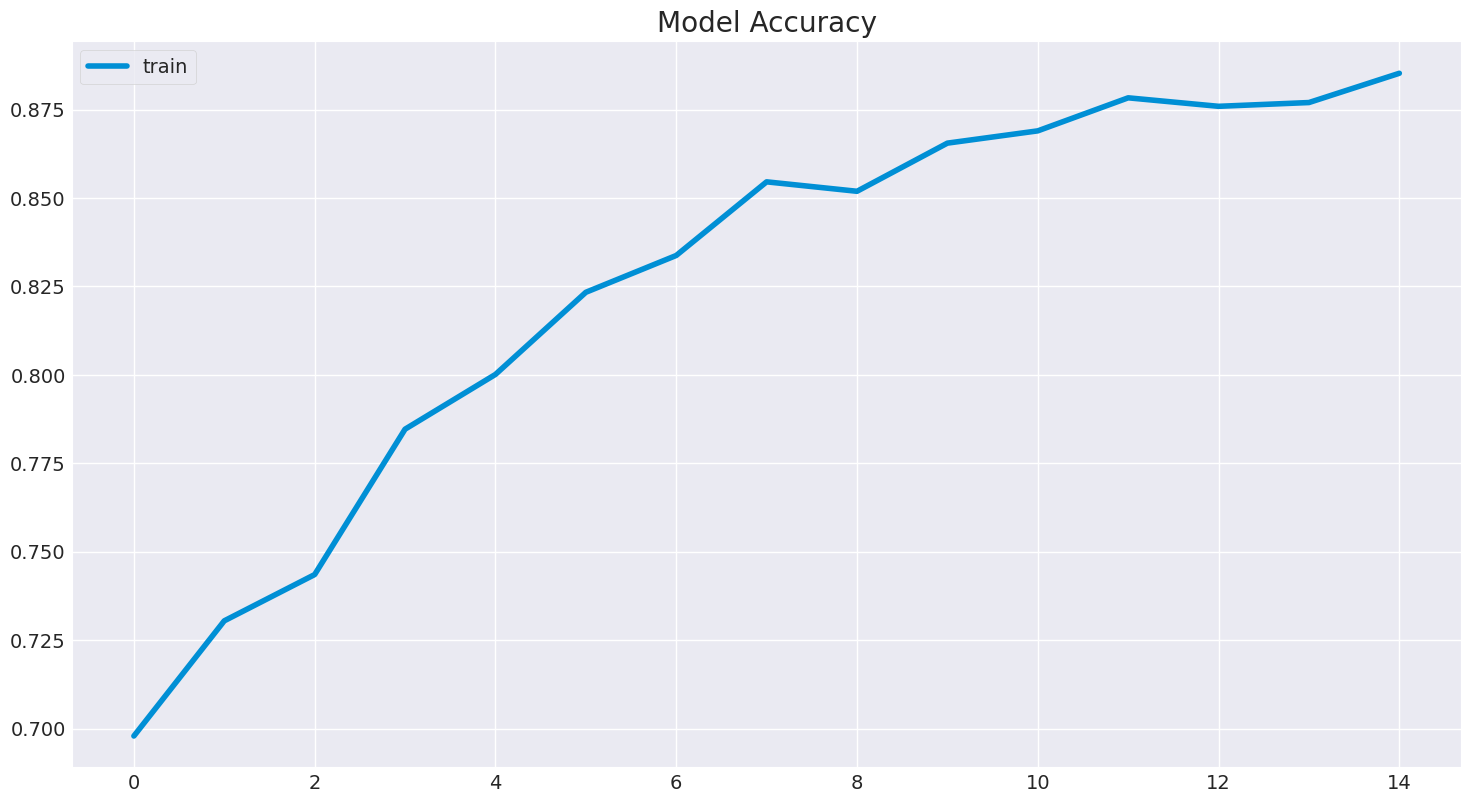

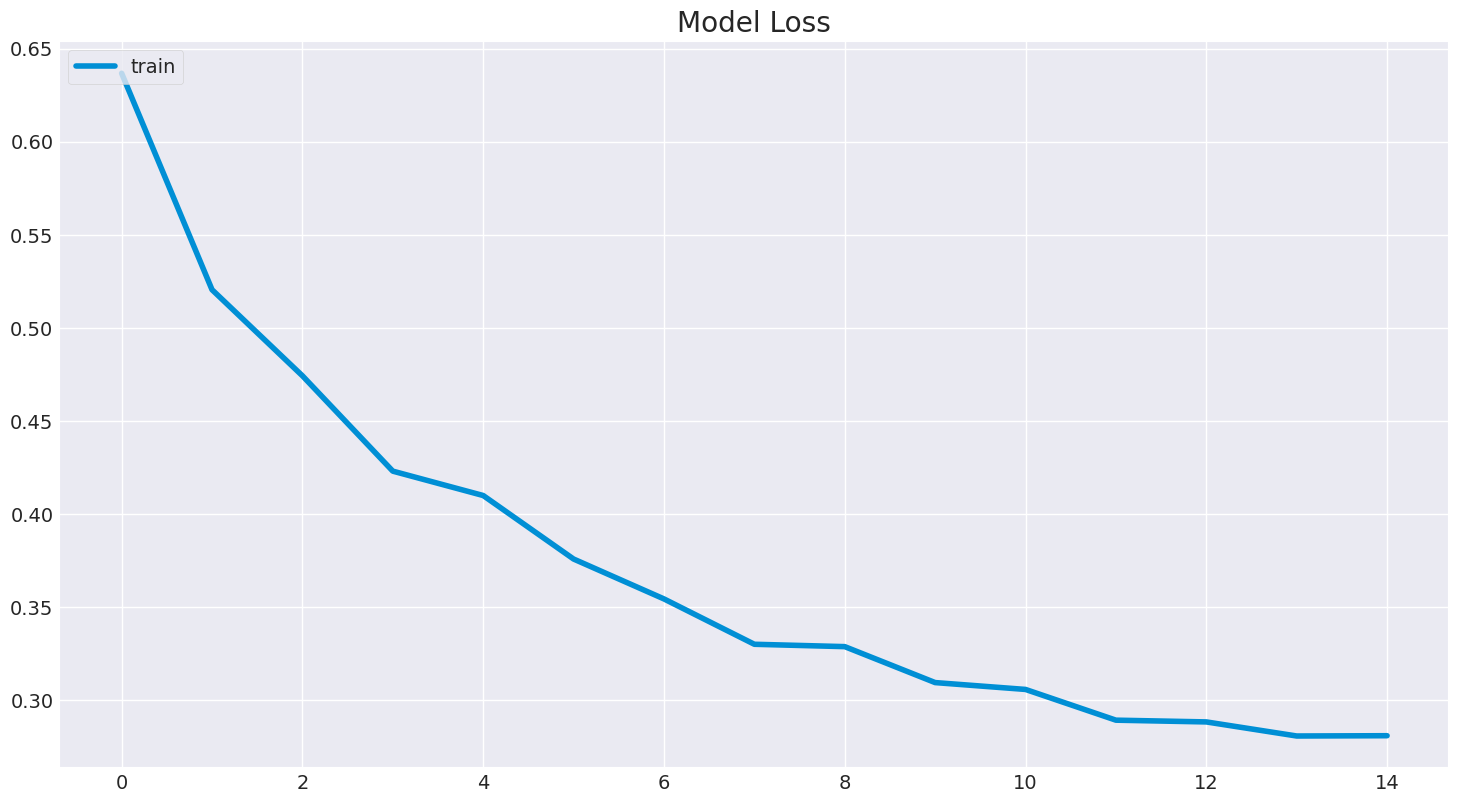

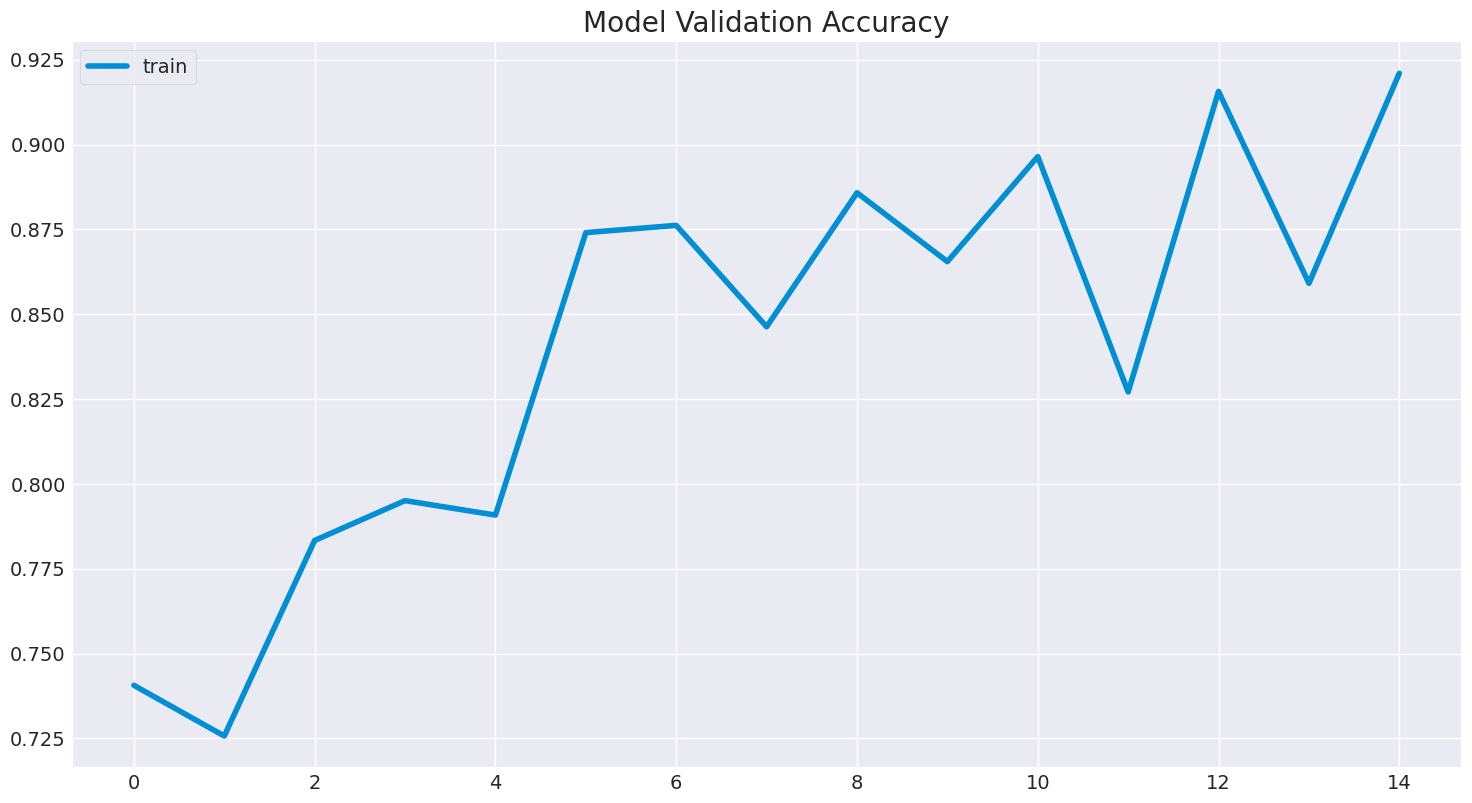

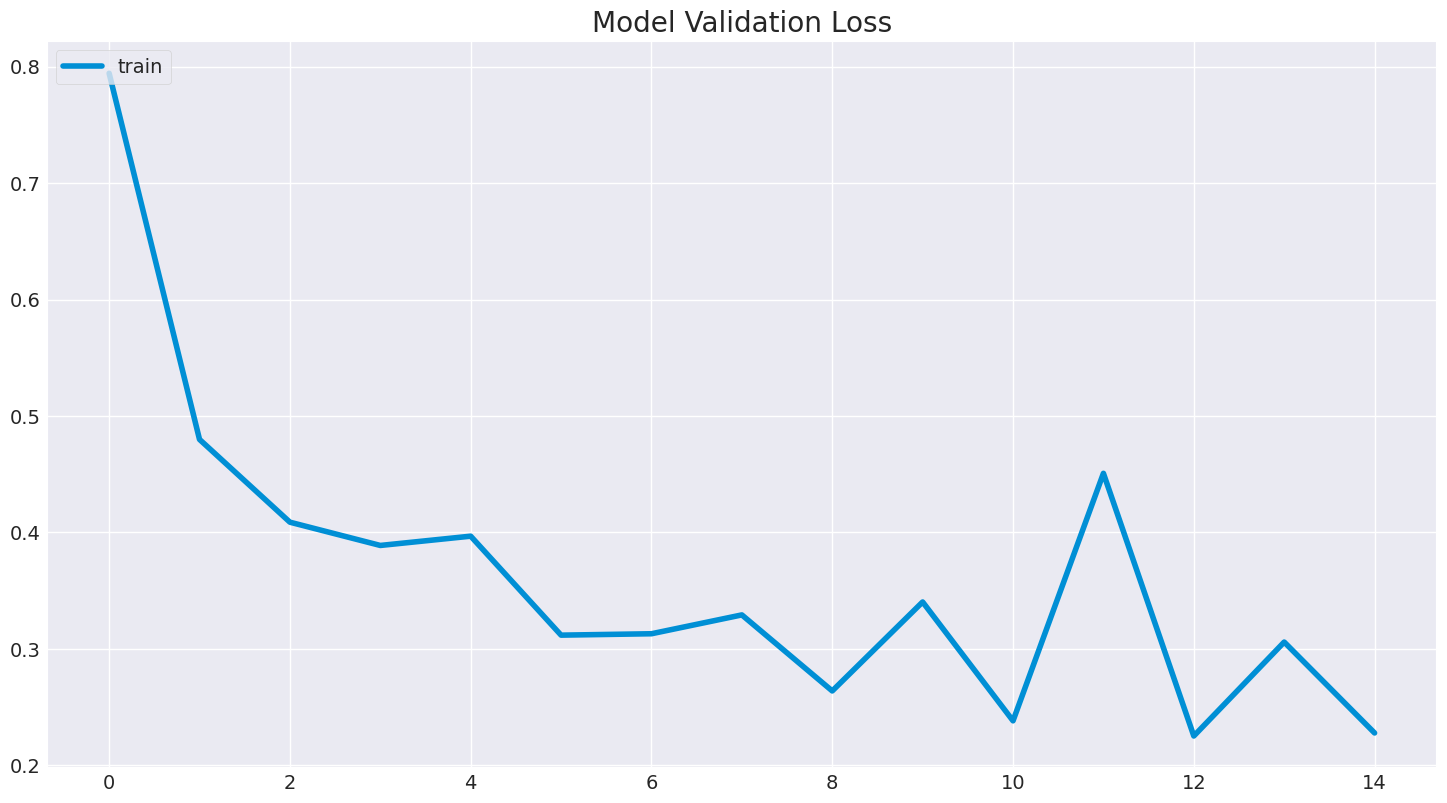

In [ ]:
plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['acc'])
plt.title('Model Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['loss'])
plt.title('Model Loss')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['val_acc'])
plt.title('Model Validation Accuracy')
plt.legend(['train'], loc='upper left')
plt.show()

plt.figure(figsize=(16, 9))
plt.plot(history.epoch, history.history['val_loss'])
plt.title('Model Validation Loss')
plt.legend(['train'], loc='upper left')
plt.show()

In [ ]:
pred = model.predict(X_train)
precisions, recalls, thresholds = precision_recall_curve(y_train, pred)
fpr, tpr, thresholds2 = roc_curve(y_train, pred)

118/118 [==============================] - 1s 11ms/step


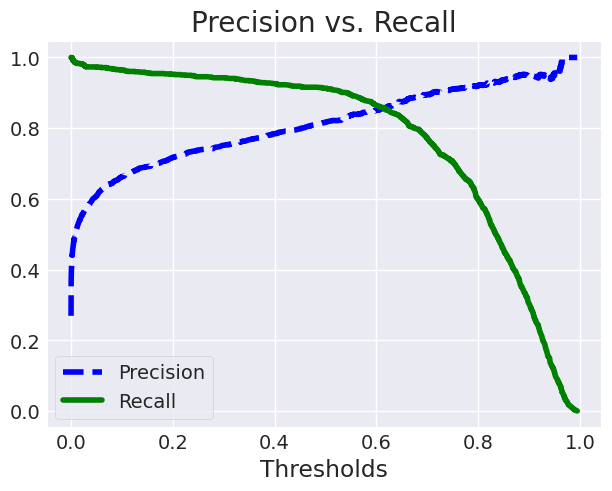

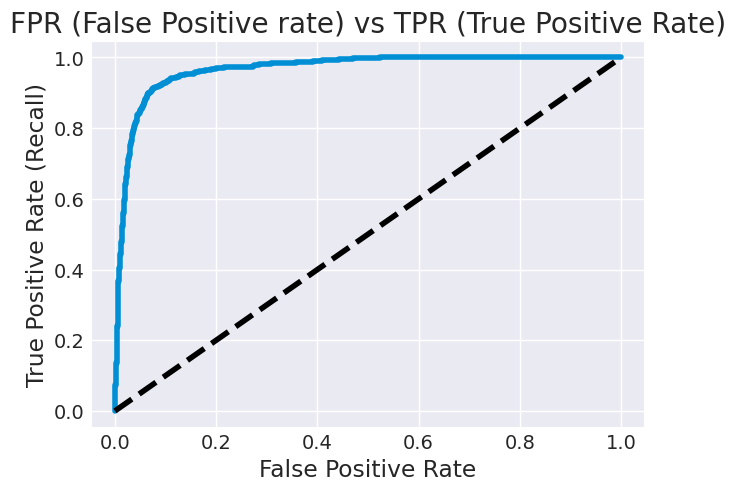

In [ ]:
def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--')
    plt.plot(thresholds, recalls[:-1], 'g-')
    plt.title('Precision vs. Recall')
    plt.xlabel('Thresholds')
    plt.legend(['Precision', 'Recall'], loc='best')
    plt.show()

def plot_roc(fpr, tpr):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('FPR (False Positive rate) vs TPR (True Positive Rate)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.show()
    
plot_precision_recall(precisions, recalls, thresholds)
plot_roc(fpr, tpr)

In [ ]:
predictions = model.predict(X_test)

37/37 [==============================] - 0s 11ms/step


In [ ]:
binary_predictions = []
threshold = thresholds[np.argmax(precisions >= 0.80)]
for i in predictions:
    if i >= threshold:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

In [ ]:
from sklearn.metrics import f1_score
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))
print("F1 score on testing set", f1_score(binary_predictions, y_test))

Accuracy on testing set: 0.9163822525597269
Precision on testing set: 0.9300911854103343
Recall on testing set: 0.8031496062992126
F1 score on testing set 0.8619718309859156


[Text(0, 0.5, 'PNEUMONIA'), Text(0, 1.5, 'NORMAL')]

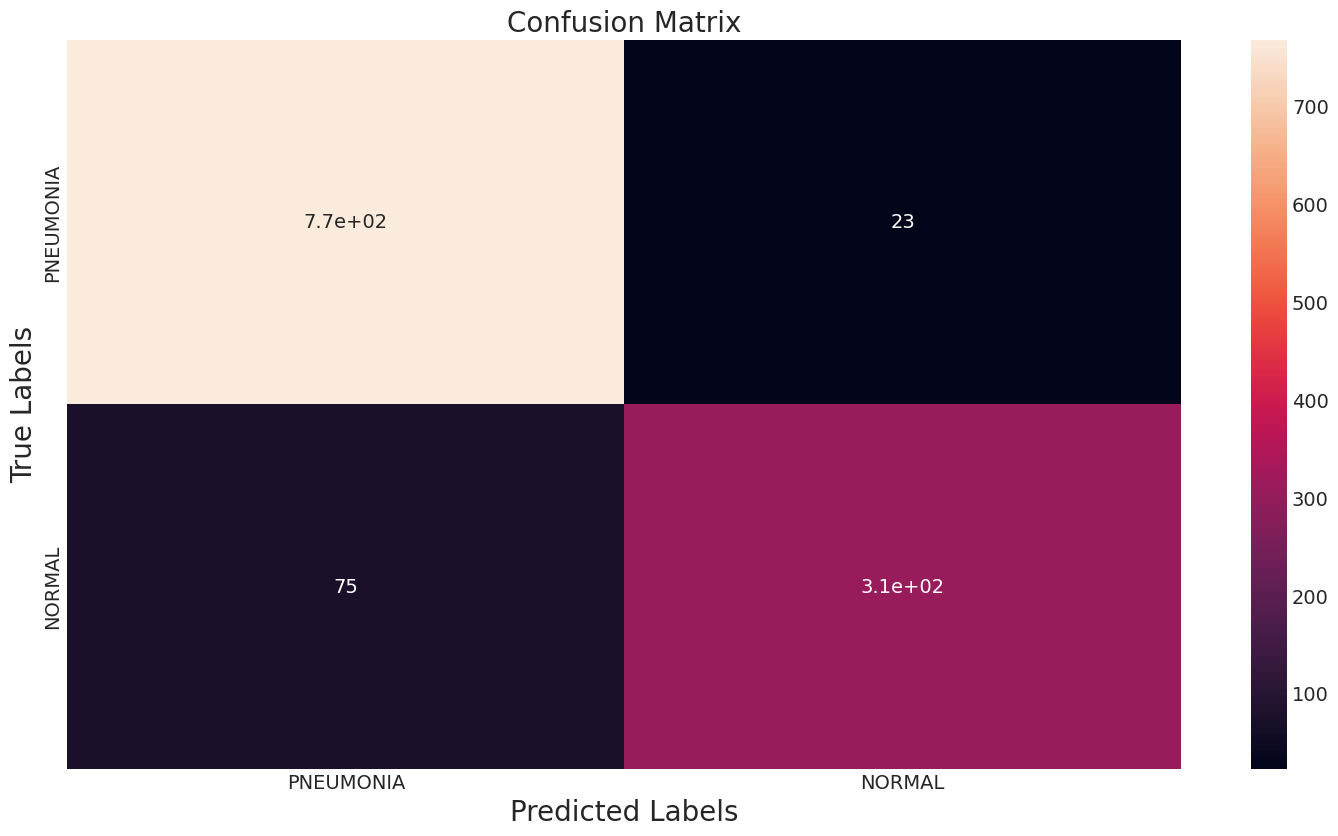

In [ ]:
matrix = confusion_matrix(binary_predictions, y_test)
plt.figure(figsize=(16, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

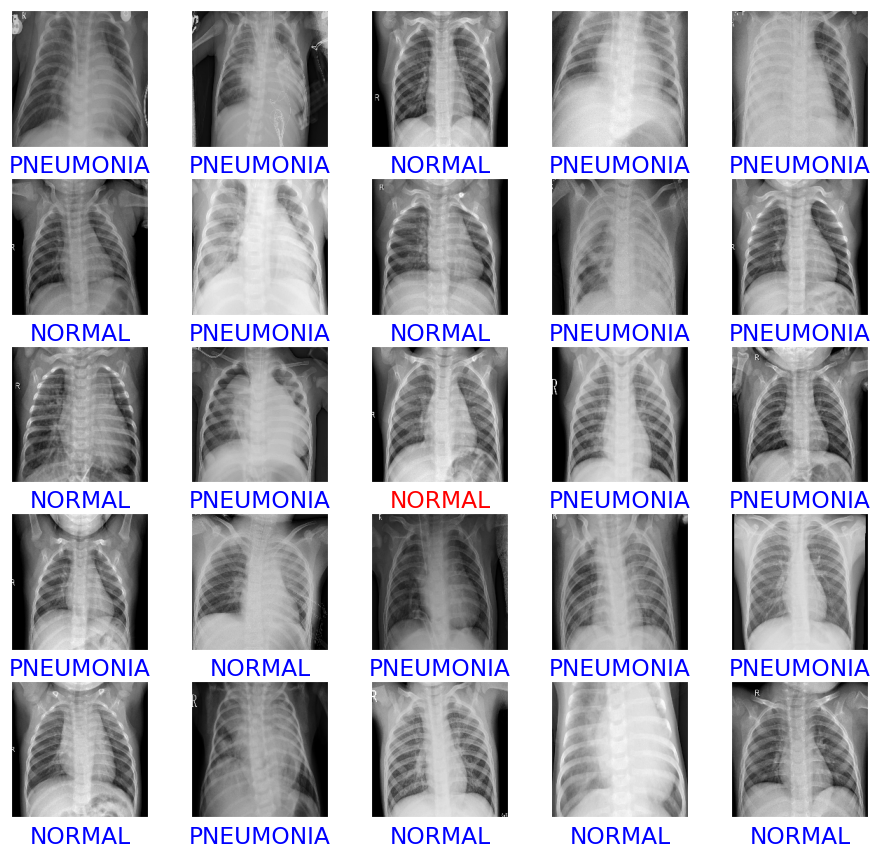

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train.reshape(-1, img_size, img_size)[i], cmap='gray')
    if(binary_predictions[i]==y_test[i]):
        plt.xlabel(labels[binary_predictions[i]], color='blue')
    else:
        plt.xlabel(labels[binary_predictions[i]], color='red')
plt.show()